
# CS 222/326 — Problem 4: Data Analysis & Visualization (Jupyter)

This notebook implements the required coding tasks:

1. **Read** the Excel dataset (Sheets: `Shapes`, `Objects`, `Tangency`)  
2. **Display** contents in a convenient format  
3. **Count** shapes by type (like the table in the prompt)  
4. **Build** a unified table via LEFT JOINs and show the **first 15 rows**  
5. **Save** outputs (counts and unified preview) for submission  
6. **(Optional)** Plot a bar chart of counts (single plot, no custom colors)


In [258]:

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.patches import Ellipse, Circle, Rectangle, RegularPolygon




## 1) Pick dataset path


In [259]:

DATASET_PATH = 'data.xlsx'



## 2) Load sheets


In [260]:

shapes = pd.read_excel(DATASET_PATH, sheet_name='Shapes')
objects = pd.read_excel(DATASET_PATH, sheet_name='Objects')
tangency = pd.read_excel(DATASET_PATH, sheet_name='Tangency')

print('Shapes (first 10):')
display(shapes.head(10))
print('\nObjects (first 10):')
display(objects.head(10))
print('\nTangency (first 10):')
display(tangency.head(10))


Shapes (first 10):


,shape_code,name,color,unit_width,unit_height
0,ellipse,Ellipse,orange,3,1
1,rectangle,Rectangle,grey,1,1
2,pentagon,Pentagon,blue,1,1
3,hexagon,Hexagon,yellow,1,1
4,triangle,Triangle,green,1,1
5,circle,Circle,red,1,1



Objects (first 10):


,id,shape_code,x,y,radius
0,1,ellipse,8.0,0.0,2.0
1,2,ellipse,3.0,0.0,1.5
2,3,circle,-8.0,0.0,1.0
3,4,circle,0.0,5.0,0.7
4,5,rectangle,0.0,-7.0,1.3
5,6,rectangle,-1.5,0.0,1.4
6,7,rectangle,0.5,8.2,0.8
7,8,pentagon,0.5,1.0,3.0
8,9,pentagon,4.0,0.7,2.0
9,10,pentagon,-8.8,0.2,2.2



Tangency (first 10):


,id,object_id,target_type,target_axis_id,target_object_id,contains
0,1,1,axis,x,NaN,NaN
1,2,2,axis,x,NaN,NaN
2,3,3,axis,x,NaN,NaN
3,4,4,axis,y,NaN,NaN
4,5,5,axis,y,NaN,NaN
5,6,6,axis,x,NaN,NaN
6,7,6,axis,y,NaN,NaN
7,8,12,axis,x,NaN,NaN
8,9,2,object,NaN,1.0,0.0
9,10,1,object,NaN,2.0,0.0


## 3) Count objects by shape

In [261]:

obj_shapes = objects.merge(shapes[['shape_code', 'name', 'color']], on='shape_code', how='left')
counts = (obj_shapes.groupby('name', dropna=False)['id']
          .count()
          .reset_index(name='Count')
          .rename(columns={'name': 'Shape Name'})
          .sort_values(['Count', 'Shape Name'], ascending=[False, True])
          .reset_index(drop=True))

print(counts.to_string(index=False))


Shape Name  Count
  Pentagon      3
 Rectangle      3
    Circle      2
   Ellipse      2
   Hexagon      1
  Triangle      1



## 4) Build unified table


In [262]:

# Base: objects + shapes
base = objects.merge(shapes, on='shape_code', how='left', suffixes=('', '_shape'))

# Join tangency (note: may duplicate rows for objects with multiple tangency records)
tang = tangency.rename(columns={'object_id':'object_id_t',
                               'target_type':'t_target_type',
                               'target_axis_id':'t_target_axis_id',
                               'target_object_id':'t_target_object_id',
                               'contains':'t_contains'})

unified = base.merge(tang, left_on='id', right_on='object_id_t', how='left')

# Reorder columns for readability
front_cols = ['id','shape_code','x','y','size']
shape_cols = [c for c in ['name','color','unit_width','unit_height'] if c in unified.columns]
t_cols = ['t_target_type','t_target_axis_id','t_target_object_id','t_contains']
ordered = [c for c in front_cols if c in unified.columns] + shape_cols + t_cols
others = [c for c in unified.columns if c not in ordered]

unified = unified[ordered + others]

preview15 = unified.head(15)
display(preview15)

# UNIFIED_CSV = 'unified.csv'
# preview15.to_csv(UNIFIED_CSV, index=False)
# print('Saved unified preview to:', UNIFIED_CSV)


,shape_code,x,y,name,color,unit_width,unit_height,t_target_type,t_target_axis_id,t_target_object_id,t_contains,id_x,radius,id_y,object_id_t
0,ellipse,8.0,0.0,Ellipse,orange,3,1,axis,x,NaN,NaN,1,2.0,1,1
1,ellipse,8.0,0.0,Ellipse,orange,3,1,object,NaN,2.0,0.0,1,2.0,10,1
2,ellipse,8.0,0.0,Ellipse,orange,3,1,object,NaN,9.0,0.0,1,2.0,18,1
3,ellipse,3.0,0.0,Ellipse,orange,3,1,axis,x,NaN,NaN,2,1.5,2,2
4,ellipse,3.0,0.0,Ellipse,orange,3,1,object,NaN,1.0,0.0,2,1.5,9,2
5,circle,-8.0,0.0,Circle,red,1,1,axis,x,NaN,NaN,3,1.0,3,3
6,circle,-8.0,0.0,Circle,red,1,1,object,NaN,10.0,0.0,3,1.0,16,3
7,circle,0.0,5.0,Circle,red,1,1,axis,y,NaN,NaN,4,0.7,4,4
8,circle,0.0,5.0,Circle,red,1,1,object,NaN,8.0,0.0,4,0.7,13,4
9,rectangle,0.0,-7.0,Rectangle,grey,1,1,axis,y,NaN,NaN,5,1.3,5,5



## 5) Plot counts with Matplotlib


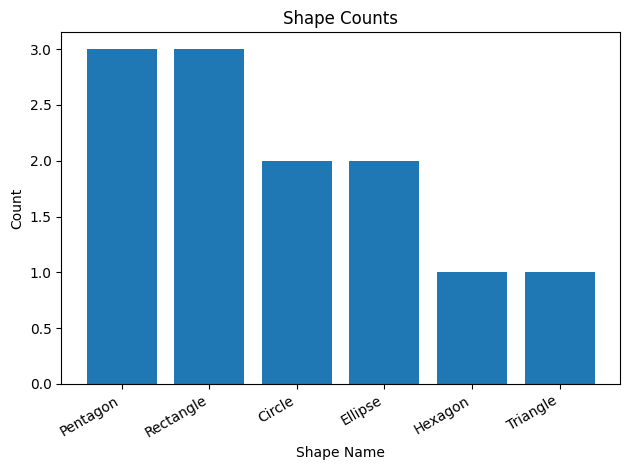

In [263]:

plt.figure()
plt.bar(counts['Shape Name'], counts['Count'])
plt.title('Shape Counts')
plt.xlabel('Shape Name')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


## 6) Plot diagram with Matplotlib

In [264]:
TP = 0.5

def rgba(c, a=TP):
    try:
        return to_rgba(str(c).strip(), a)
    except ValueError:
        return to_rgba("grey", a)

def add_ellipse(ax, cx, cy, w, h, color):
    patch = Ellipse((cx, cy), width=2*w, height=h, facecolor=rgba(color))
    ax.add_patch(patch)
    return (cx - w/2, cy - h/2, cx + w/2, cy + h/2)

def add_circle(ax, cx, cy, r, color):
    patch = Circle((cx, cy), r, facecolor=rgba(color))
    ax.add_patch(patch)
    return (cx - r, cy - r, cx + r, cy + r)

def add_rect(ax, cx, cy, w, h, color):
    llx, lly = cx - w/2, cy - h/2
    patch = Rectangle((llx, lly), w, h, facecolor=rgba(color))
    ax.add_patch(patch)
    return (llx, lly, llx + w, lly + h)

def add_regular_poly(ax, cx, cy, n, radius, color):
    patch = RegularPolygon(
        (cx, cy),
        n,
        radius=radius,
        facecolor=to_rgba(str(color).strip(), TP),
        linewidth=1
    )
    ax.add_patch(patch)
    return (cx - radius, cy - radius, cx + radius, cy + radius)


In [265]:
def dims_from_radius(row):
    r  = row['radius']
    uw = float(row.get('unit_width', 1.0))
    uh = float(row.get('unit_height', 1.0))
    W  = 2.0 * r * uw
    H  = 2.0 * r * uh

    return r, W, H

def draw_row(ax, row):
    name  = str(row['name']).strip().lower()
    color = row.get('color', '0.6')
    cx, cy = float(row['x']), float(row['y'])

    r, W, H = dims_from_radius(row)

    if name == 'ellipse':
        return add_ellipse(ax, cx, cy, W, H, color)
    if name == 'circle':
        return add_circle(ax, cx, cy, 2.0*r, color)
    if name == 'rectangle':
        return add_rect(ax, cx, cy, W, H, color)
    if name == 'triangle':
        return add_regular_poly(ax, cx, cy, 3, r, color)
    if name == 'pentagon':
        return add_regular_poly(ax, cx, cy, 5, r, color)
    if name == 'hexagon':
        return add_regular_poly(ax, cx, cy, 6, r, color)

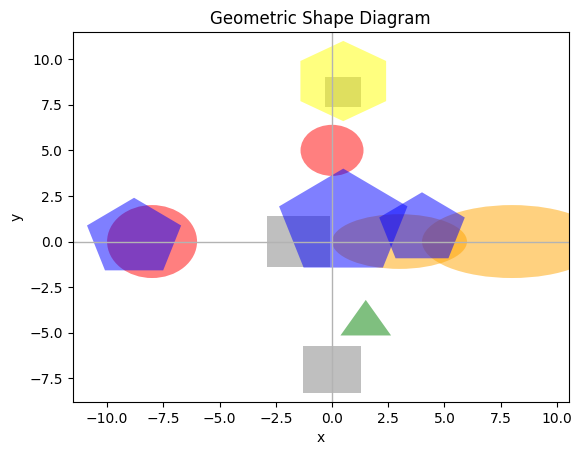

In [266]:
fig, ax = plt.subplots()
ax.axhline(0, color='0.7', linewidth=1)
ax.axvline(0, color='0.7', linewidth=1)

xmin = ymin = 0
xmax = ymax = 0
for _, r in obj_shapes.iterrows():
    (lx, ly, rx, ry) = draw_row(ax, r)
    xmin, ymin = min(xmin, lx), min(ymin, ly)
    xmax, ymax = max(xmax, rx), max(ymax, ry)

pad_x = 0.5 * (xmax - xmin) * 0.05
pad_y = 0.5 * (ymax - ymin) * 0.05
ax.set_xlim(xmin - pad_x, xmax + pad_x)
ax.set_ylim(ymin - pad_y, ymax + pad_y)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Geometric Shape Diagram')
plt.show()